In [2]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset

import gpu_utils
tf.get_logger().setLevel('INFO')
try:
    gpu_utils.setup_gpus()
except ValueError as ex:
    print(ex)

BUFFER_SIZE = 10000
BATCH_SIZE = 64  # 512


1 Physical GPUs, 1 Logical GPUs


In [3]:
data = dataset.load_file(BATCH_SIZE, 0.1, filenames=['texts/bible.txt', 'texts/short_table.txt', 'texts/treasure_island.txt'])

In [8]:
EMBED_DIM = 64

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(data.letters_size, EMBED_DIM,  input_length=data.maxlen,
#                               batch_size=BATCH_SIZE,
#                               mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(EMBED_DIM*4, return_sequences=True), merge_mode='sum'),
#     tf.keras.layers.Dense(EMBED_DIM*4, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(data.niqqud_size),
# ])
# best: mean_squared_logarithmic_error, stateless

inp = tf.keras.Input(shape=(data.maxlen,), batch_size=BATCH_SIZE)
h = tf.keras.layers.Embedding(data.letters_size, EMBED_DIM,  mask_zero=True)(inp)
h = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(EMBED_DIM*4, return_sequences=True), merge_mode='sum')(h)
h = tf.keras.layers.Dense(EMBED_DIM*4, activation='relu')(h)
output = tf.keras.layers.Dense(data.niqqud_size)(h)

model = tf.keras.Model(inputs=[inp], outputs=[output])

model.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

plot_model(model, to_file='model.png')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 400)]               0         
_________________________________________________________________
embedding_1 (Embedding)      (64, 400, 64)             4928      
_________________________________________________________________
bidirectional_1 (Bidirection (64, 400, 256)            494592    
_________________________________________________________________
dense_2 (Dense)              (64, 400, 256)            65792     
_________________________________________________________________
dense_3 (Dense)              (64, 400, 16)             4112      
Total params: 569,424
Trainable params: 569,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
%tensorboard --logdir logs\fit

In [9]:
EPOCHS = 2

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
while True:
    try:
        history = model.fit(data.input_texts, data.niqqud_texts,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(data.input_validation, data.niqqud_validation),
                          verbose=1,
                          callbacks=[
                              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
                              # tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, verbose=1),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=0.001),
                              # tensorboard_callback,
                          ]
                )
    except RuntimeError as ex:
        import sys
        print(ex, file=sys.stderr)
        #model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))
    else:
        break

Train on 39398 samples, validate on 4378 samples
Epoch 1/2
39398/39398 [==============================] - 63s 2ms/sample - loss: 0.0024 - accuracy: 0.9393 - val_loss: 0.0017 - val_accuracy: 0.9579
Epoch 2/2
39398/39398 [==============================] - 55s 1ms/sample - loss: 0.0015 - accuracy: 0.9634 - val_loss: 0.0014 - val_accuracy: 0.9680


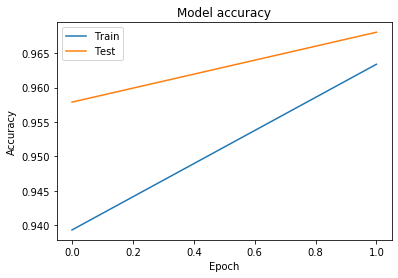

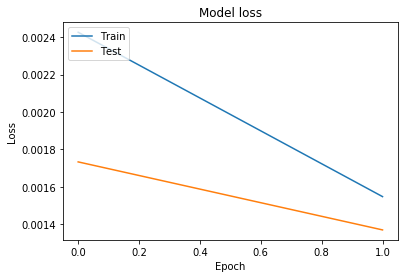

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(output)])

def print_predictions(batch):
    results = data.merge(batch, model.predict(batch))

    for r in results:
        print(r)



print_predictions(data.input_texts[0:BATCH_SIZE])

וַיְהִי רָעַב בִימִי דָוּד שֶלֹש שְנִים שָנָה אַחְרֵי שָנָה וַיִבַקֵש דָוֹד אֶת-פְנֵי יְהוָה וַיַאמֶר יְהוָה אֶל-שָאוּל וְאֶל-בֵית הַדָמִים עַל אֹשֶר-הַמִית אֶת-הַגְבְעָנִים
בֵינֵיהֶם צִמְחוּ כַמָה אַרָנִים פְזוּרִים, שֶהִתְנַשָאוּ לְגַבָה עַשְרִים מֶטֶר, מִי פָחוֹת וּמִי יוֹתֵר
בְּאוֹתוֹ רֶגַע שֶׁקְעָה הַשָמֵש וְרוּחַ-הָעָרֶב הַשְׁמִיעָה שֶׁרִיקְתָה מִבִּין עָצֵי הָאָרֶן הַגְבוֹהִים, הַנָעִים בְתְפַלַת עַרְבִית
וּבְנֵי אַרָם עוֹץ וְחוֹל וְגָתֶר וּמֵש
“בְּמְשָׁךְ שֶׁלֹשִׁים שָׁנָה הַפְלַגְתִּי בִּים,” אָמַר, "רָאִיתִי טוֹב וְגַם רַע, הַצְלָחוֹת וְגַם בִזִיוֹנוֹת, מִזֶג-אוִיר נִחְמַד וְגַם מִזַפֶת
אִם-בִגְפוֹ יָבָא בְגְפוֹ יָצָא אִם-בְעַל אֹשֶה הוּא וַיִצְאָה אִשְתוֹ עֵמוֹ
"קַפִּיטַן סְמוֹלֵט, "אָמַר טְרִילוֹנִי, “הַבִּקְתָּה הַזֹאת אֵינָה נִרְאִית מִן הָאָנִיָה, הֵם מְטוּחִים בְּוֹדְאִי אֶל הַדֶגֶל
הַיָשָר לִפְנֵי דְלֶק הָרוֹפֵא אַחְרֵי תוֹקְפוּ בְּמוֹרָד הַגְבְעָה, הַפִילוּ עַל הַקְרְקַע וְשֶלַח אוֹתוֹ לְנַפְשו, כְּשֶׁהוּא נִגְרַר עַל צָדוֹ וְחָתְךְ גָדוֹל מִכְסָה אֶת פָּנָיו
וְעַתָה 

In [ ]:
del model

In [ ]:
print(history.history['val_accuracy'])